In [90]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
Running on the GPU


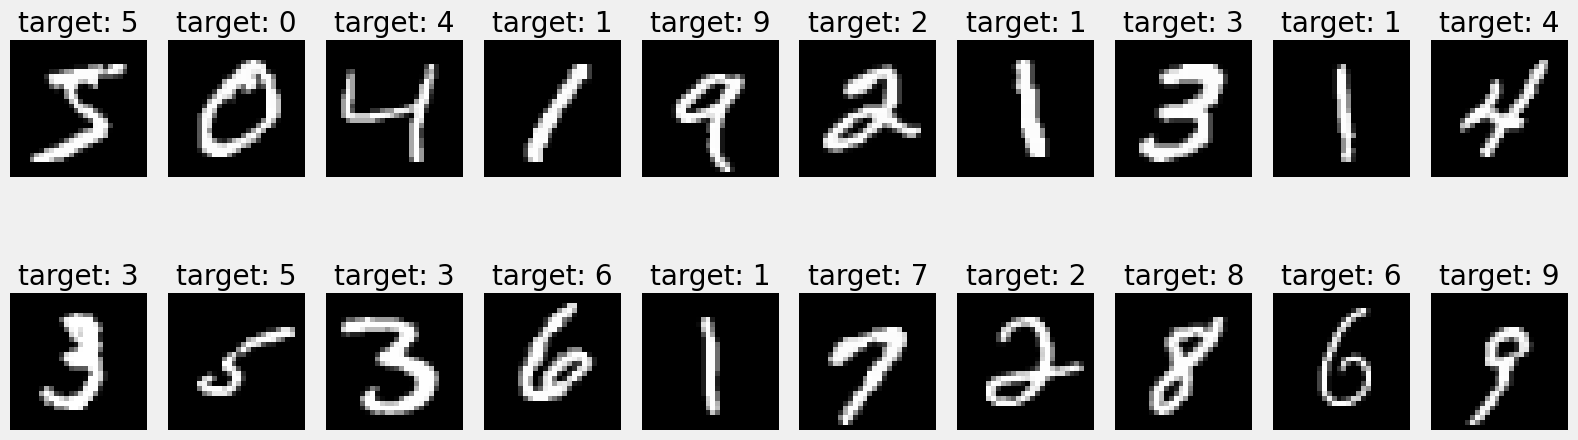

In [92]:
fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(loader.dataset.data[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {loader.dataset.targets[i]}")
    print(loader.dataset.data[i].shape)
    
plt.tight_layout()


if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

In [93]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [94]:
model = AutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/40, Loss: 0.007513
Epoch 2/40, Loss: 0.006516
Epoch 3/40, Loss: 0.005084
Epoch 4/40, Loss: 0.004953
Epoch 5/40, Loss: 0.004037
Epoch 6/40, Loss: 0.005096
Epoch 7/40, Loss: 0.005052
Epoch 8/40, Loss: 0.004335
Epoch 9/40, Loss: 0.003816
Epoch 10/40, Loss: 0.004353
Epoch 11/40, Loss: 0.003468
Epoch 12/40, Loss: 0.003555
Epoch 13/40, Loss: 0.004623
Epoch 14/40, Loss: 0.003338
Epoch 15/40, Loss: 0.004228
Epoch 16/40, Loss: 0.004101
Epoch 17/40, Loss: 0.003797
Epoch 18/40, Loss: 0.004281
Epoch 19/40, Loss: 0.004282
Epoch 20/40, Loss: 0.004061
Epoch 21/40, Loss: 0.004568
Epoch 22/40, Loss: 0.003911
Epoch 23/40, Loss: 0.003987
Epoch 24/40, Loss: 0.003730
Epoch 25/40, Loss: 0.004444
Epoch 26/40, Loss: 0.003821
Epoch 27/40, Loss: 0.004154
Epoch 28/40, Loss: 0.003708
Epoch 29/40, Loss: 0.002935
Epoch 30/40, Loss: 0.004298
Epoch 31/40, Loss: 0.003862
Epoch 32/40, Loss: 0.003899
Epoch 33/40, Loss: 0.003647
Epoch 34/40, Loss: 0.004288
Epoch 35/40, Loss: 0.003554
Epoch 36/40, Loss: 0.003885
E

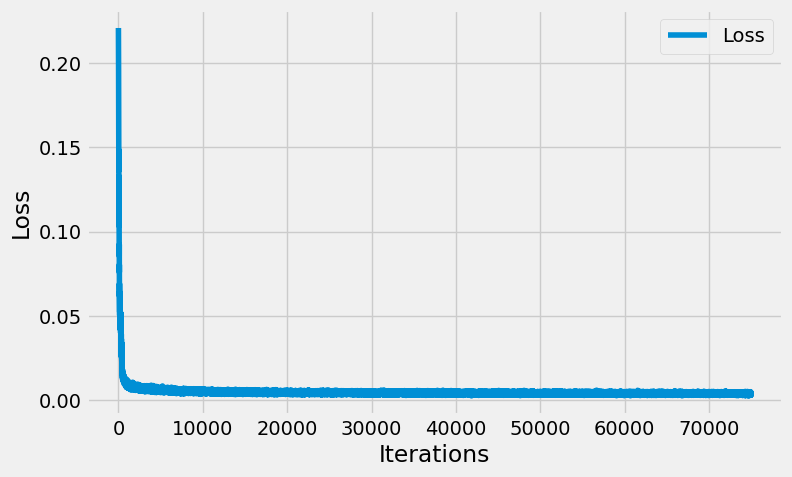

In [95]:
epochs = 40
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(images.size(0), -1, 28, 28).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


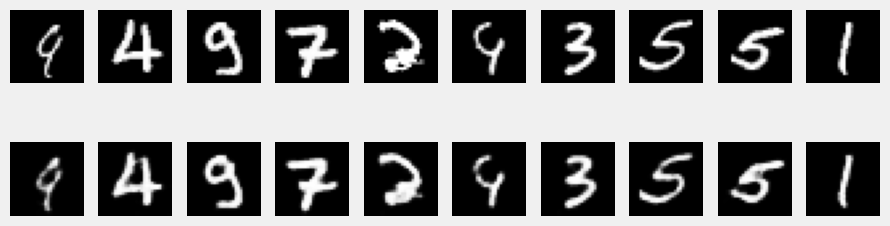

In [96]:
model.eval()
dataiter = iter(loader)
images, _ = next(dataiter)

images = images.view(images.size(0), -1, 28, 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()


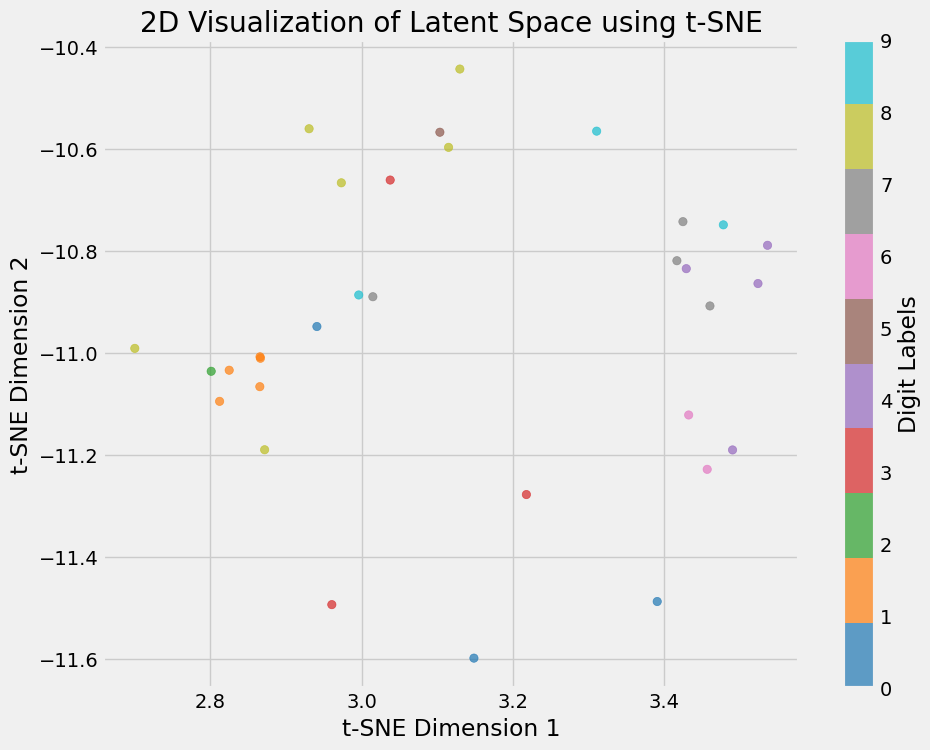

In [97]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_latent_space(model, data_loader, n_samples=1000):
    device = next(model.parameters()).device  # Get device (CPU or CUDA)
    model.eval()

    with torch.no_grad():
        images, labels = next(iter(data_loader))
        images, labels = images[:n_samples], labels[:n_samples]  # Limit samples
        images = images.to(device)
        labels = labels.numpy()

        # Pass images through encoder to get latent vectors
        latent_vectors = model.encoder(images.view(images.size(0), 1, 28, 28))  # Ensure correct shape
        latent_vectors = latent_vectors.view(images.size(0), -1).cpu().numpy()  # Flatten

    # Apply t-SNE to reduce latent space to 2D
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot the 2D latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10), label='Digit Labels')
    plt.title('2D Visualization of Latent Space using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Call function to visualize
visualize_latent_space(model, data_loader=loader, n_samples=10000)
